In [1]:
import json

import nibabel as nib
import sys
from matplotlib import pyplot as plt
sys.path.append('bin')
import bin.analysis as analysis
import bin.representation_geometry as geo
import numpy
import numpy as np
import torch
from torch import nn
import pandas as pd
import networkx as nx
import graspologic as gr
from bin.graphIO import GraphIO

220628-13:03:50,619 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.6.1
Intel Hardware Acceleration is not enabled. 


In [36]:
# grab the shape color beta matrix
beta = '/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/representational/pollux_combined_beta.nii.gz'
beta_nii = nib.load(beta)
affine = beta_nii.affine
header = beta_nii.header
beta = np.array(beta_nii.get_fdata())[:, :, :, :]


In [37]:
brain_mask_nii = nib.load('/Volumes/bc7/projects/ColorContrastSpatialFrequency/derivatives/surface/pollux/mri/rbrain.nii')
brain_mask = torch.from_numpy(np.array(brain_mask_nii.get_fdata().astype(bool)))

In [38]:
atlas_nii = nib.load("/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/pollux_rois_20220628/atlas.nii.gz")
atlas = torch.round(torch.from_numpy(atlas_nii.get_fdata())).int()
lookup = pd.read_csv("/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/pollux_rois_20220628/atlas_lookup.txt", header=0, index_col=0, delimiter='\t')

In [39]:
atlas_idxs = sorted(torch.unique(atlas).tolist())[1:]

In [45]:
import math

flat_beta = torch.from_numpy(beta)[atlas > 0]
beta_mag = torch.sum(flat_beta, dim=1)
cutoff = math.ceil(1* len(beta_mag))
_, sort_idxs = torch.sort(beta_mag, descending=True)
to_use = sort_idxs[:cutoff]
flat_beta = flat_beta[to_use]


In [46]:
proj, vecs, vals = geo.pca(flat_beta, noisy=True, n_components=2)
flat_atlas = atlas[atlas > 0]
flat_atlas = flat_atlas[to_use]

In [47]:
def rgb_to_hex(r, g, b):
  return ('{:X}{:X}{:X}').format(int(r), int(g), int(b))

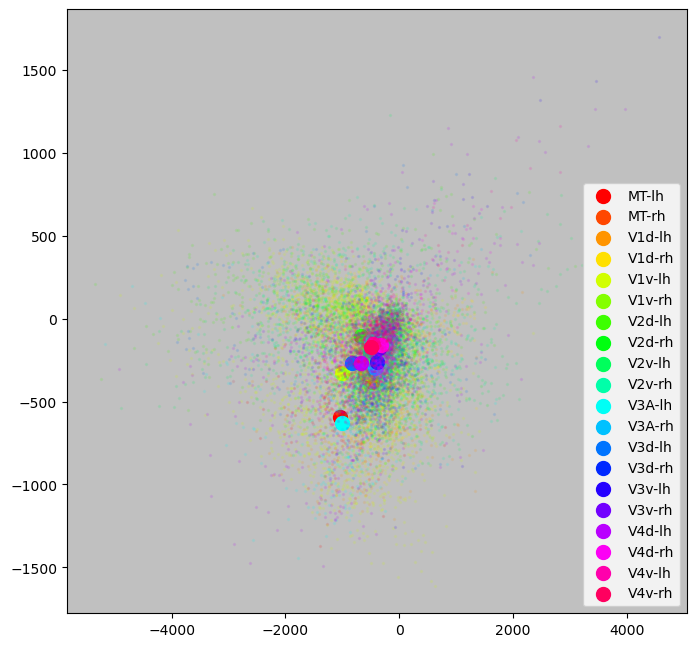

In [82]:
fig, ax = plt.subplots()
fig.set_size_inches((8, 8))
idxs = torch.randperm(proj.shape[0])[:]
proj_sample = proj[idxs, :]
cmap = plt.get_cmap('hsv')
num_rois = len(atlas_idxs)
for i, key in enumerate(atlas_idxs[:]):
    c = cmap(float(i / num_rois))
    label = lookup.loc[key]['Label Name:']
    roi_proj = proj_sample[flat_atlas[idxs]==key, :]
    mean = torch.mean(roi_proj, dim=0)
    ax.scatter(roi_proj[:, 0], roi_proj[:, 1], s=2, color=c, alpha=.1)
    ax.scatter(mean[0], mean[1], s=100, color=c, marker='o', label=label)
# ax.set_ylim(-10, 10)
# ax.set_xlim(25, 125)
ax.set_facecolor('silver')
plt.legend()
plt.show()


In [83]:
print(vecs[:, 1:3].T.tolist())
print(len(vecs[1]))

[[6.802019383238598, 12.416527649593077, 11.867672165447226, 3.16208042443189, 4.444118903972976, 8.449869792565517, 9.814405380684308, 4.690522885423502, 1.640838536735794, 7.294966307388177, 11.524829084779885, 6.966802540217115, 6.065201990339344, 7.174507609088808, 5.263425312180091, -6.198164609115991, 7.91561479797103, 8.290447430826525, 9.695846040752935, -1.644629675997927, 8.659850928251673, 5.830772186857304, 10.893860349246047, 5.0886738999908045, 3.140910779337042, 7.259782212658631, 8.95614540299609, 7.9615784647929395, 3.670053191759284, 11.211482030755336, 7.656794348916916, 1.3963814206088476, 3.7057757852788598, 0.26360667202311344, -0.8689332899553308, -4.3066531064312725, -10.736535052635302, -44.30669302799199, -20.301610506047748, -5.299934807007549, -1.8598473196088576, -1.2518776739934834, -18.99744395965569, -5.4355174136560915, -2.7973564861281233, -16.361962441406938, -42.862126954386625, -11.159837907345706], [4.349906245428275, -1.1745476473901948, 2.4351501

BIC for 1 components is 1764645.3637569258
BIC for 2 components is 1741277.9492778822
BIC for 3 components is 1737194.541206865
BIC for 4 components is 1734078.3929607728
BIC for 5 components is 1733133.1919866404
BIC for 6 components is 1732336.1101864304
BIC for 7 components is 1732008.5145218626
BIC for 8 components is 1731796.6356652707
BIC for 9 components is 1731162.203664366
BIC for 10 components is 1731402.765736136
BIC for 11 components is 1731492.7332572048


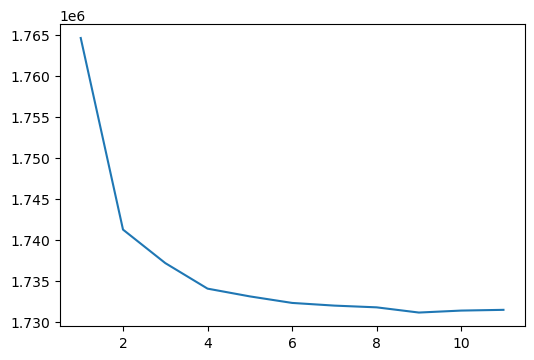

In [84]:
from sklearn.mixture import GaussianMixture
component_min = 1
component_max = 12
bics = []
gmms = []
gmm_beta = flat_beta @ vecs[:, 1:12].numpy()
for n_comp in range(component_min, component_max):
    gmm = GaussianMixture(n_components=n_comp)
    gmm.fit(gmm_beta)
    bic = gmm.bic(gmm_beta)
    print("BIC for", n_comp, "components is", bic)
    bics.append(bic)
    gmms.append(gmm)
plt.plot(range(component_min, component_max), bics)

In [85]:
best_gmm = gmms[3]
print(best_gmm.means_)

[[-1.44471850e+03 -9.56519305e+01  5.99432401e+01 -7.48967059e+00
  -5.91271776e+01 -3.81344264e+00  8.60409894e+00  1.37546078e+00
   1.02926311e+01 -6.54682035e+00 -3.25466693e+00]
 [-3.57814009e+02 -2.06307347e+02  1.45024398e+01 -4.00750087e+01
  -5.59271419e+00  1.37580639e+01 -6.90467032e+00  4.94746937e+00
   3.80124325e+00 -4.97545052e+00 -3.05128649e+00]
 [-9.67833118e+02 -4.17785185e+01  1.61788433e+01 -3.03050787e+01
  -8.33128687e+00  1.59939113e+01 -1.24863324e+01  2.06759674e+00
   4.47597330e+00  1.50945734e+00  2.41546172e+00]
 [-3.68181063e+02 -4.38493278e+02  3.41707976e+01 -6.54120204e+01
   2.28707762e+00  1.78201467e+01 -8.68609365e+00  1.13715242e+01
   3.84352865e+00 -4.36186071e+00 -4.05426175e+00]]


In [86]:
labels = best_gmm.predict(gmm_beta)
unique_labels = np.unique(labels)
for roi in atlas_idxs:
    roi_idxs = (flat_atlas == roi).numpy()
    roi_size = np.count_nonzero(roi_idxs)
    for label in unique_labels:
        label_idxs = (labels==label)
        truth = numpy.logical_and(roi_idxs, label_idxs)
        overlap = np.count_nonzero(truth)
        percent_label = overlap / roi_size
        print(100 * float(percent_label), "% of roi", lookup.loc[roi]['Label Name:'], "assigned to label ", int(label))

34.234234234234236 % of roi MT-lh assigned to label  0
2.7027027027027026 % of roi MT-lh assigned to label  1
8.108108108108109 % of roi MT-lh assigned to label  2
54.95495495495496 % of roi MT-lh assigned to label  3
38.13559322033898 % of roi MT-rh assigned to label  0
12.711864406779661 % of roi MT-rh assigned to label  1
17.796610169491526 % of roi MT-rh assigned to label  2
31.35593220338983 % of roi MT-rh assigned to label  3
5.947955390334572 % of roi V1d-lh assigned to label  0
32.465923172242874 % of roi V1d-lh assigned to label  1
22.428748451053284 % of roi V1d-lh assigned to label  2
39.15737298636927 % of roi V1d-lh assigned to label  3
0.0 % of roi V1d-rh assigned to label  0
62.658650634602544 % of roi V1d-rh assigned to label  1
20.240480961923847 % of roi V1d-rh assigned to label  2
17.100868403473616 % of roi V1d-rh assigned to label  3
10.23535851122058 % of roi V1v-lh assigned to label  0
18.226600985221676 % of roi V1v-lh assigned to label  1
27.312534209085932 % o

In [56]:
print(vecs[:, :2].T.tolist())
print(len(vecs[1]))

[[36.173536877547406, 42.60075583430666, 54.56452557034705, 93.4522614240291, 44.13379678870632, 64.17397627501161, 80.01744212059846, 129.50199343821293, 32.30829937163895, 48.04009165977861, 60.29291115009995, 132.98577993222122, 39.26455490060971, 28.603878277934054, 65.22849668379155, 120.6950127719088, 52.745558757444094, 54.39885307475686, 59.728245945996626, 109.90738288277952, 45.4730364271815, 71.63653373912206, 100.34924282578619, 121.23816483422814, 44.1271072005406, 59.52523663184827, 62.842264854863856, 85.37610016874629, 36.268659450826235, 40.978212669410276, 59.1560684120923, 105.44523259555228, 64.64939553940894, 89.32739641742718, 107.39434761590532, 124.17741447519121, 110.86010203704183, 130.06797790229692, 36.174875434193574, 86.45115253176385, 34.06338420221097, 6.016441109018137, 76.83678356018181, 98.02007166820255, 29.166503197737125], [-0.38728418512683477, -1.2172845410095747, -1.0279331117819446, -0.47066090116246156, -1.3583754782887707, -0.5519658939463669

In [145]:

corr_adj, roi_idx, rdms, pvals = geo.pairwise_rsa(flat_beta, atlas=flat_atlas, ignore_atlas_base=False, metric='cosine')

Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(2, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(3, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(4, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(5, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(6, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(7, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(8, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(9, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(10, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(11, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(12, dtype=torch.int32)
Computed Correlation  tensor(1, dtype=torch.int32) ,  tensor(13, dtype=torch.int32)


In [146]:
roi_names = {i:lookup.loc[idx.item()]['Label Name:'] for i, idx in enumerate(roi_idx)}

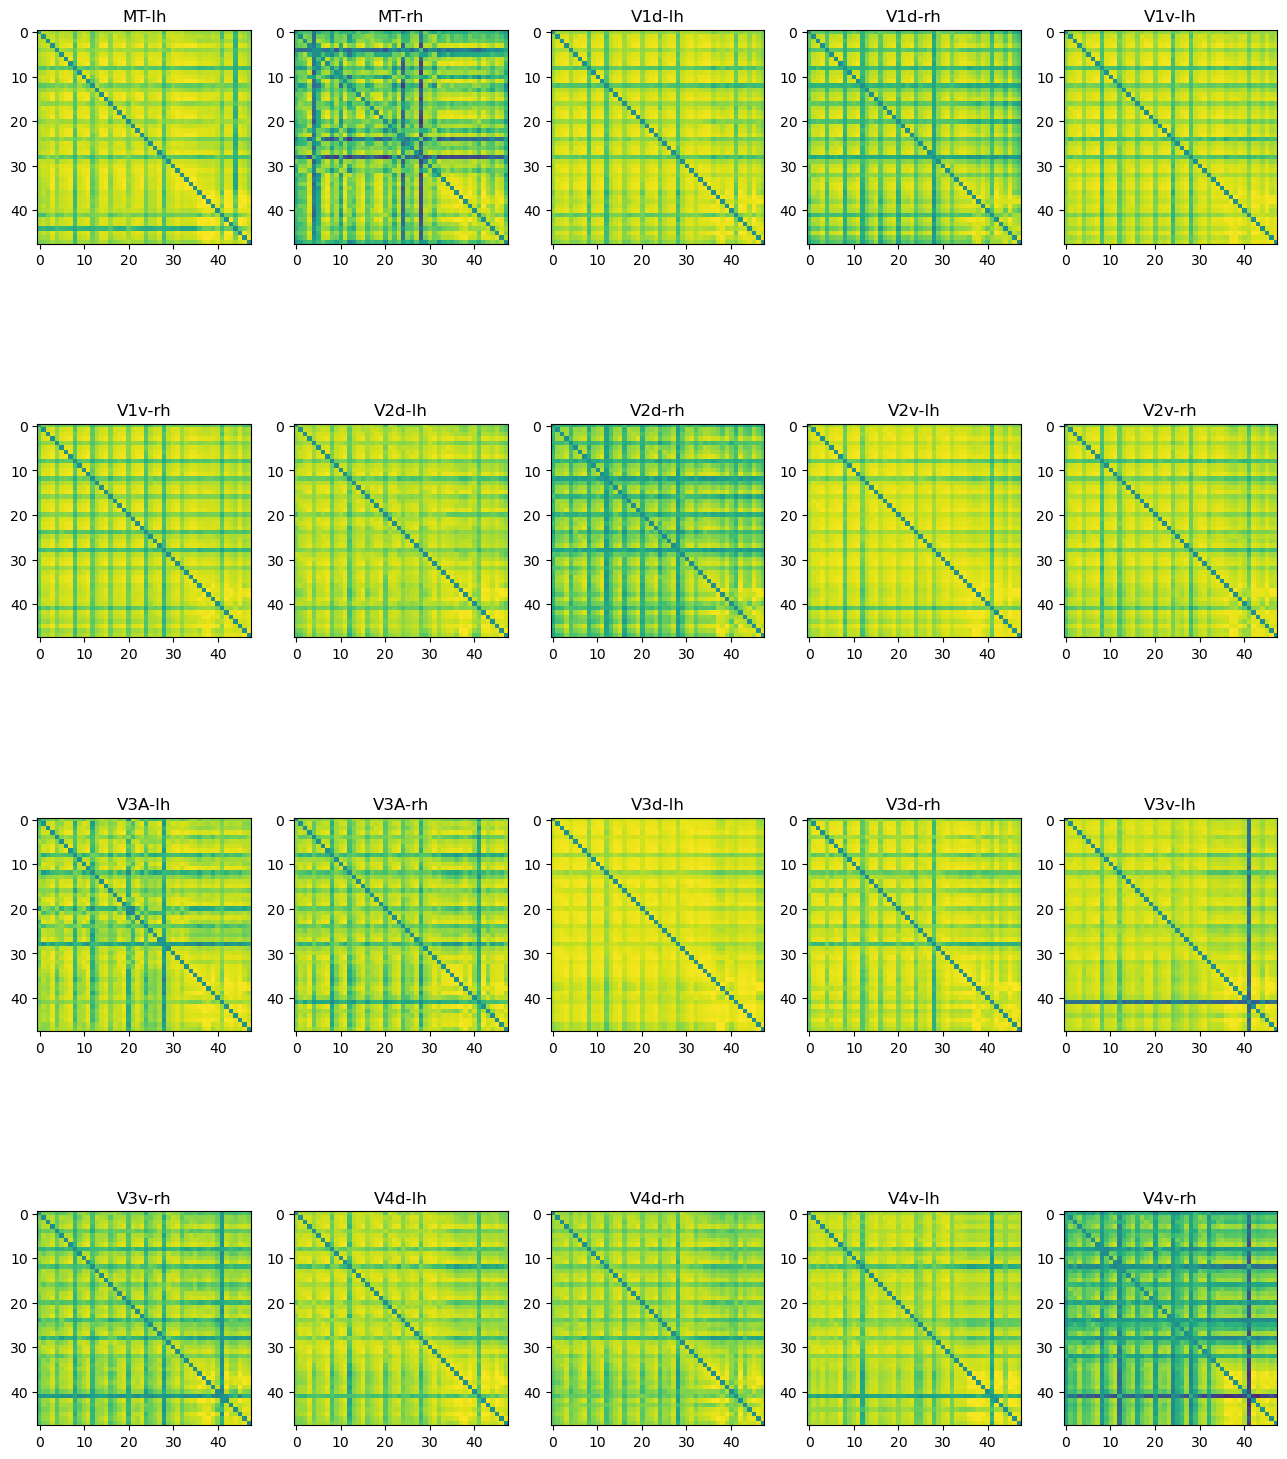

In [149]:
fig, axs = plt.subplots(4, 5)
for i, rdm in enumerate(rdms):
    rdm = rdm.numpy()
    size = flat_beta.shape[1]
    rdm_mat = np.zeros((size, size))
    rdm_mat[np.triu_indices(rdm_mat.shape[0], k = 1)] = rdm
    rdm_mat = rdm_mat + rdm_mat.T
    idx = (int(np.floor(i / 5)), int(i % 5))
    axs[idx[0], idx[1]].imshow(rdm_mat, vmin=-1, vmax=1)
    axs[idx[0], idx[1]].set_title(roi_names[i])
fig.set_size_inches(16, 20)
plt.show()

In [150]:
np_adj = corr_adj.numpy()
weight_std = np.std(np_adj)
weight_mean = np.mean(np_adj)
print(weight_mean)
print(weight_std)

0.7891774
0.20197125


In [151]:
import networkx as nx
roi_corr_graph = nx.from_numpy_array(np_adj, create_using=nx.Graph)
# roi_atlas = roi_atlas.get_fdata()
for node in roi_corr_graph.nodes():
    roi_corr_graph.nodes[node]['roi_name'] = roi_names[node]
    roi_corr_graph.nodes[node]['rdm'] = rdms[node].tolist()
    roi_corr_graph.nodes[node]['num_dims'] = np.count_nonzero(atlas==roi_idx[node].item())

In [152]:
# from bin.graphIO import GraphIO
# for s, t, data in list(roi_corr_graph.edges(data=True)):
#     if (pvals[s, t] > .1 or np.abs(data['weight']) < .8) and np.abs(data['weight']) < .95:
#         roi_corr_graph.remove_edge(s, t)
GraphIO.dump(roi_corr_graph, "/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/representational/pollux_cor_graph_all_edge.json")

In [153]:
pos_graph = roi_corr_graph.copy()
for s, t, data in pos_graph.edges(data=True):
    pos_graph.edges[(s, t)]['weight'] = np.abs(data['weight'])
undirected_connectome, layout = gr.layouts.layout_tsne(pos_graph,
                                                       perplexity=100,
                                                       n_iter=100000)
for s, t, data in undirected_connectome.edges(data=True):
    undirected_connectome.edges[(s, t)]['weight'] = roi_corr_graph.edges[(s, t)]['weight']

/Users/loggiasr/miniconda3/envs/fmri/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/loggiasr/miniconda3/envs/fmri/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [154]:
from graspologic.layouts.classes import NodePosition
for i in range(len(layout)):
    new_data = gr.layouts.classes.NodePosition(node_id=int(layout[i].node_id),
                                               x=layout[i].x,
                                               y=layout[i].y,
                                               size=layout[i].size,
                                               community=layout[i].community)
    layout[i] = new_data
cmap = plt.get_cmap('viridis')

raw_edge_weights = np.array([edge[2]['weight'] for edge in undirected_connectome.edges(data=True)])
edge_weights = raw_edge_weights - min(raw_edge_weights)
edge_weights = edge_weights / max(edge_weights)

edge_colors = np.array([cmap(val) for val in edge_weights])

edge_widths = np.abs(raw_edge_weights) - np.min(raw_edge_weights)
edge_widths = edge_widths / max(edge_widths)
edge_widths = (1. * edge_widths) + .25

node_colors = ['#808080'] * len(undirected_connectome.nodes())
labels = {}
for n in undirected_connectome.nodes:
    if 'roi_name' in undirected_connectome.nodes[n]:
        labels[n] = undirected_connectome.nodes[n]['roi_name']
    else:
        labels[n] = 'unnamed'

In [155]:
def rgb_to_hex(r, g, b):
  return ('{:X}{:X}{:X}').format(int(r*255), int(g*255), int(b*255))

for i, edge in enumerate(undirected_connectome.edges()):
    s, t = edge
    undirected_connectome.edges[(s, t)]['color'] = rgb_to_hex(edge_colors[i][0], edge_colors[i][1], edge_colors[i][2])
    undirected_connectome.edges[(s, t)]['width'] = edge_widths[i]
for i, n in enumerate(undirected_connectome.nodes()):
    undirected_connectome.nodes[n]['graphics'] = {'x': layout[i].x,
                                                  'y': layout[i].y,
                                                  'w': layout[i].size,
                                                  'h': layout[i].size}

nx.readwrite.write_gml(undirected_connectome, "/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/representational/pollux_cor_graph.gml") # write to gml for loading with cytoscape

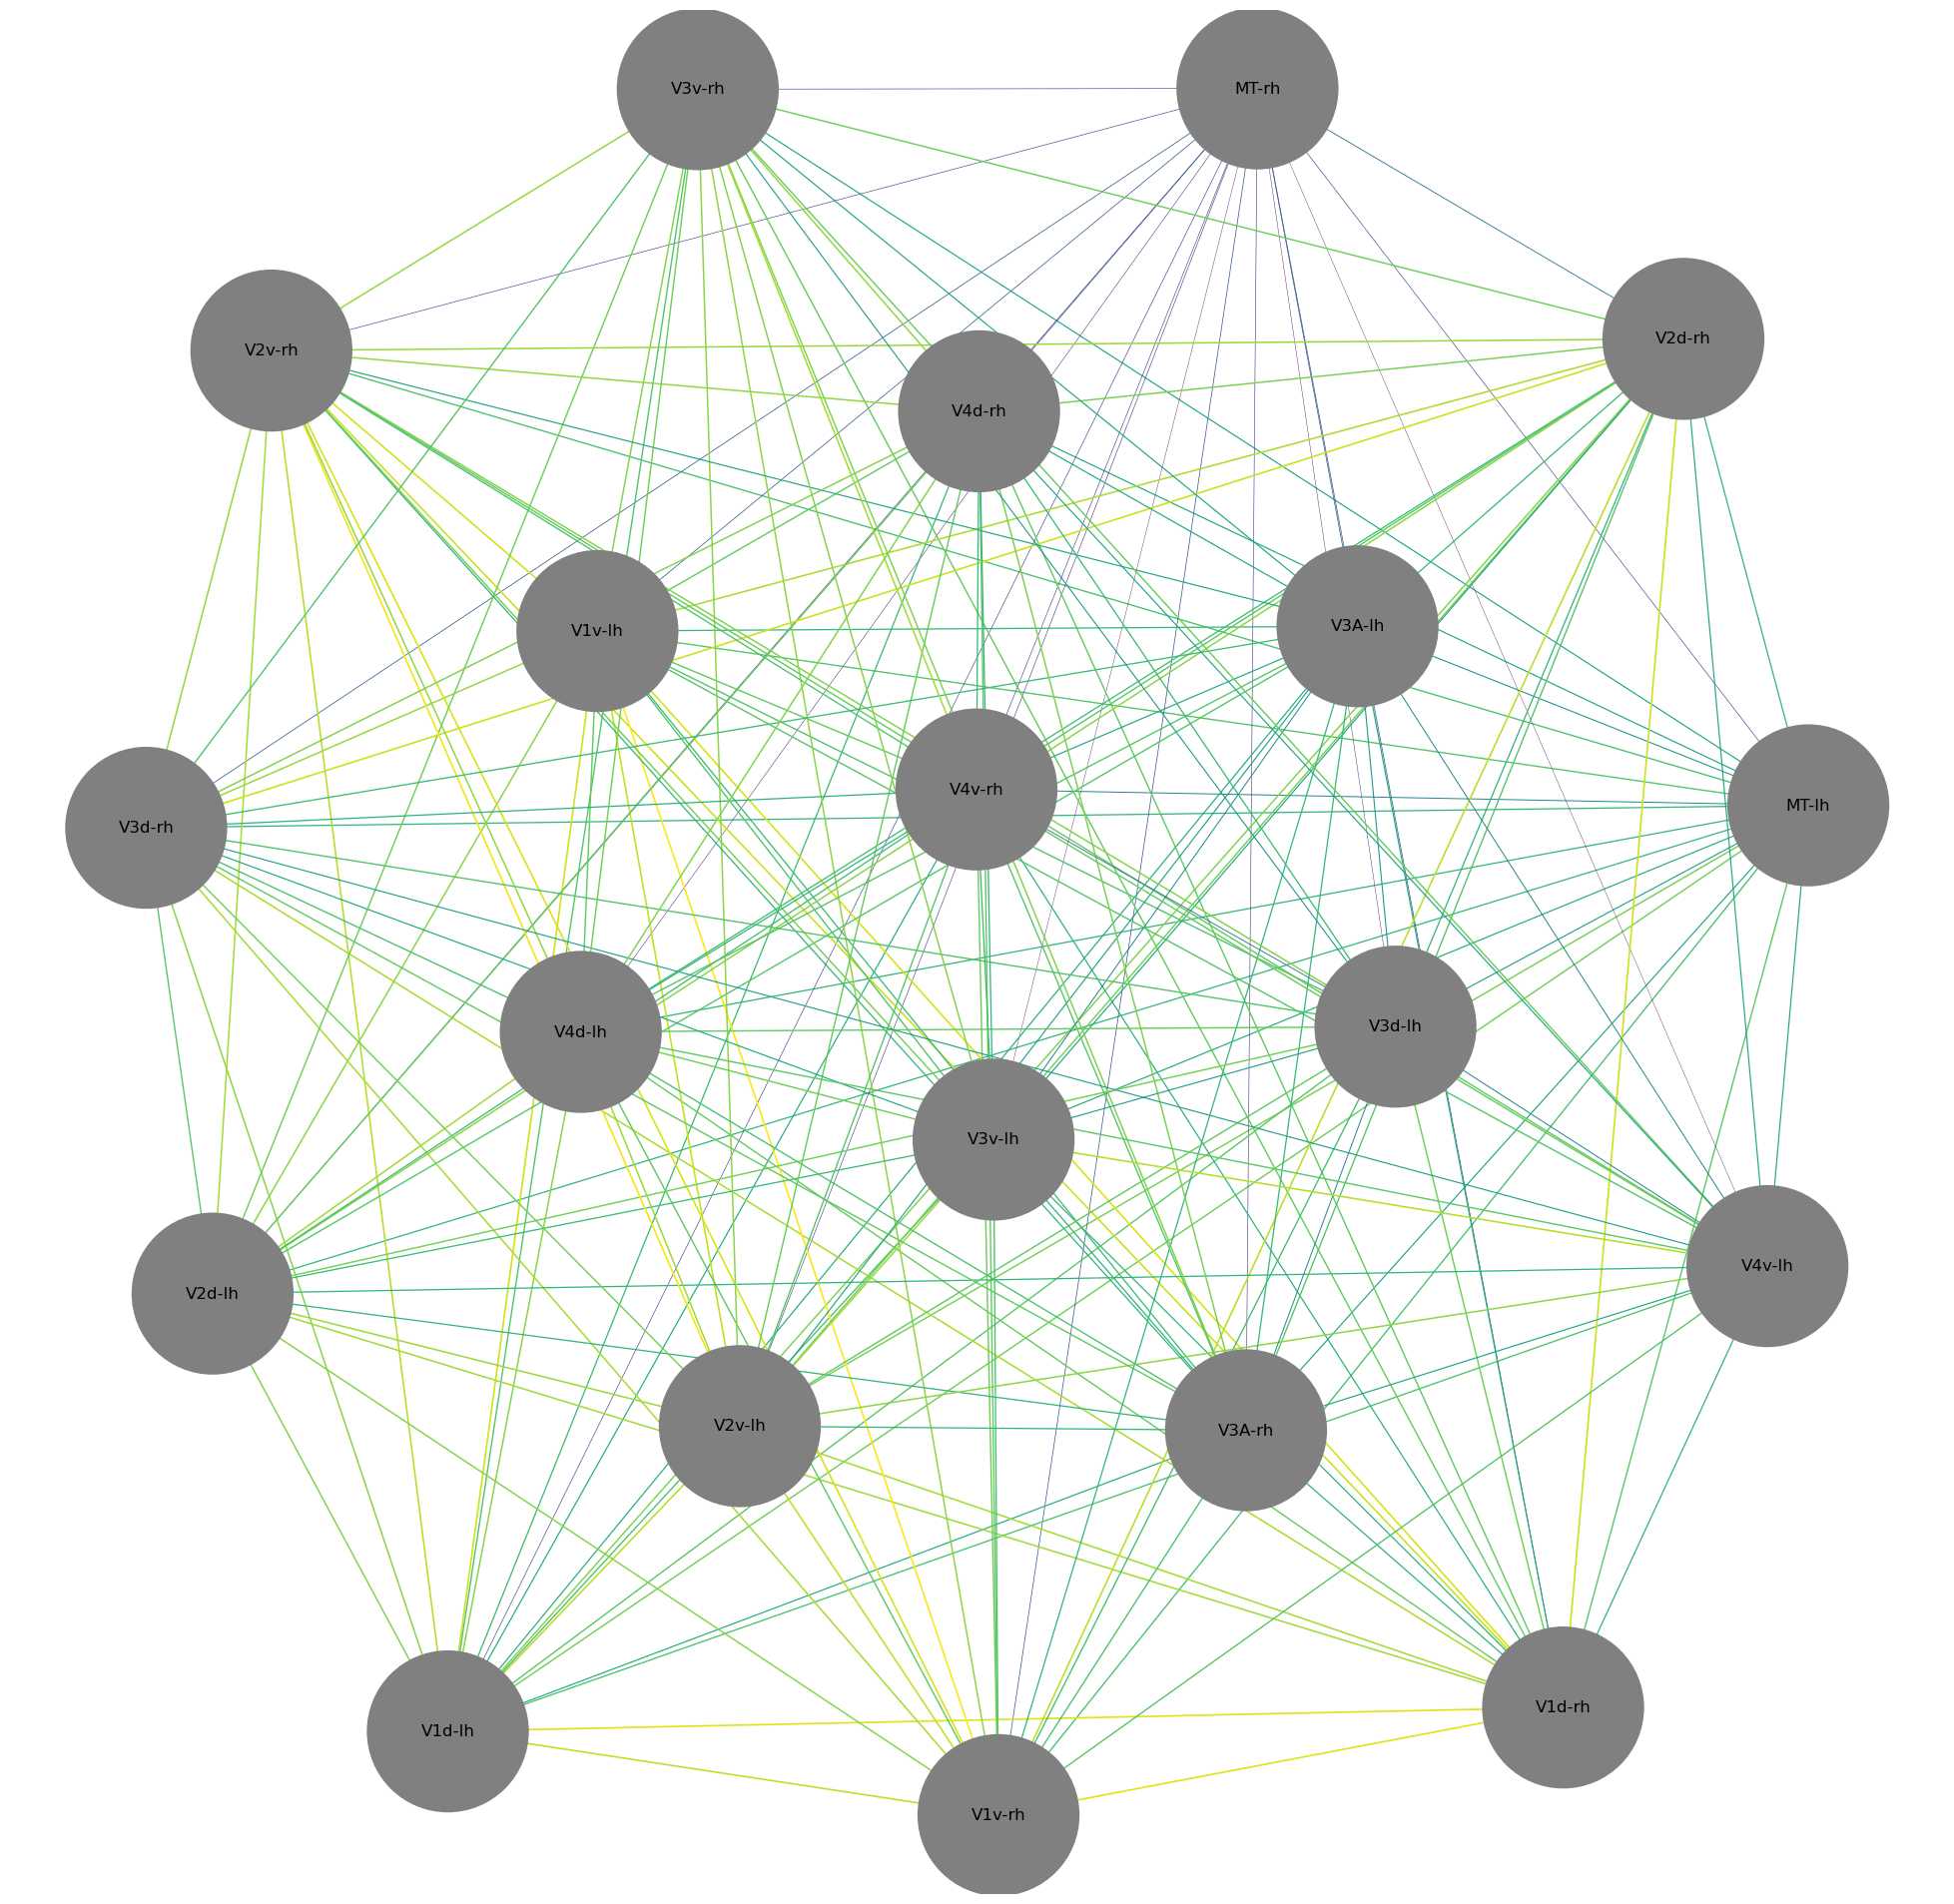

In [156]:
drawing = gr.layouts.render._draw_graph(undirected_connectome, layout, node_colors, 1.,
                                        edge_line_width=edge_widths,
                                        edge_alpha=1.,
                                        edge_colors=edge_colors,
                                        labels=labels,
                                        figure_width=25,
                                        figure_height=25)

In [157]:
from graspologic.embed import AdjacencySpectralEmbed
ase = AdjacencySpectralEmbed(n_components=2)
roi_corr_graph.remove_node(1)
embeddings = ase.fit_transform(roi_corr_graph)


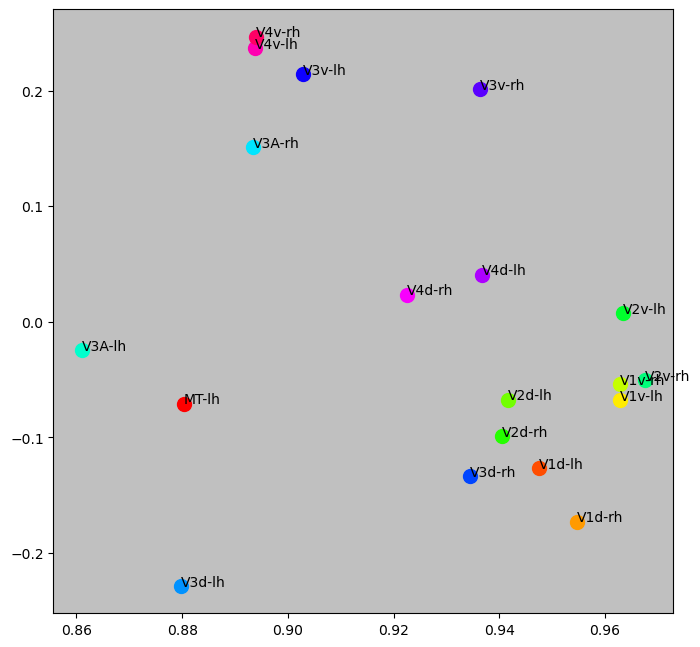

In [158]:
fig, ax = plt.subplots()
fig.set_size_inches((8, 8))

cmap = plt.get_cmap('hsv')
num_rois = len(roi_corr_graph)
for i, key in enumerate(roi_corr_graph.nodes()):
    c = cmap(float(i / num_rois))
    label = lookup.loc[key + 1]['Label Name:']
    ax.scatter(embeddings[i, 0], embeddings[i, 1], s=100, color=c, marker='o')
    ax.annotate(label, (embeddings[i, 0], embeddings[i, 1],), xytext=(0,0), textcoords='offset points')
# ax.set_ylim(-10, 10)
# ax.set_xlim(25, 125)
ax.set_facecolor('silver')
plt.show()